### Testing within-subject models

Issues need to be solved:
* Add more than $v$ to the model;
* Stim-coding with HDDMRegression (there was a tutorial on this)
* Flexible design

In [94]:
# check which python is in use.
import sys
print('Notebook is running:', sys.executable)

# further check your python version
from platform import python_version

print('The current HDDM version is', python_version())

# If you are sure that conda is installed, also check the package that install
#!conda list  # list the conda

import hddm, IPython
import numpy as np
import pandas as pd
import seaborn as sns
print('The current HDDM version is', hddm.__version__) # 0.8.0

# Warning:`IPython.parallel` package has been deprecated since IPython 4.0. 
print('The current IPython version is', IPython.__version__) 

print('The current Numpy version is', np.__version__) 

print('The current Pandas version is', pd.__version__)

print('The current seaborn version is', sns.__version__)

Notebook is running: /home/hcp4715/miniconda3/envs/hddm/bin/python
The current HDDM version is 3.7.7
The current HDDM version is 0.8.0
The current IPython version is 7.13.0
The current Numpy version is 1.18.5
The current Pandas version is 1.0.4
The current seaborn version is 0.10.1


In [2]:
%matplotlib inline

# Preparation
import os, time, csv
from datetime import date
import random

import kabuki, hddm
from patsy import dmatrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Let's first replicate the tutorial on HDDM website

http://ski.clps.brown.edu/hddm_docs/tutorial_regression_stimcoding.html

In [3]:
#import sys
# the following will save all the stdout to the txt file, which is not necessary
# sys.stdout = open('ModelRecoveryOutput.txt', 'w')

### Creating simulated data for  the experiment

set number of subjects and number of trials per level for the simulated experiment

In [4]:
n_subjects = 10
trials_per_level = 150

Next, set up parameters of the DDM for three levels and the first stimulus. 

In [5]:
level1a = {'v':.3, 'a':2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
level2a = {'v':.4, 'a':2, 't':.3, 'sv':0, 'z':.6, 'sz':0, 'st':0}
level3a = {'v':.5, 'a':2, 't':.3, 'sv':0, 'z':.7, 'sz':0, 'st':0}

Next, set up parameters for the second stimulus, where `v` is the same as for the first stimulus. This is different for `z`. In particular: `z(stimulus_b) = 1 - z(stimulus_a)`. 

In [6]:
level1b = {'v':.3, 'a':2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
level2b = {'v':.4, 'a':2, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}
level3b = {'v':.5, 'a':2, 't':.3, 'sv':0, 'z':.3, 'sz':0, 'st':0}

Now, let's generate data for both stimuli

In [7]:
random.seed(123)
np.random.seed(123)
data_a, params_a = hddm.generate.gen_rand_data({'level1': level1a,
                                                'level2': level2a,
                                                'level3': level3a},
                                              size=trials_per_level,
                                              subjs=n_subjects)

data_b, params_b = hddm.generate.gen_rand_data({'level1': level1b,
                                                'level2': level2b,
                                                'level3': level3b},
                                              size=trials_per_level,
                                              subjs=n_subjects)

In [8]:
data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)
data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*2, index=data_a.index)
mydata = data_a.append(data_b,ignore_index=True)

In [ ]:
mydata.head(10)

### Setting up the HDDM regression model

The parameter `z` is bound between `0` and `1`, but the standard linear regression does not generate values between `0` and `1`. Therefore, we use a link-function, here the inverse logit $1/(1+exp(-x))$, which transform values between plus and minus infinity into values ranging from (just above) `0` to (nearly) `1`. [this link function is related to logistic regression].

Next, we need to ensure that bias is $z$ for one stimulus and $1-z$ for the other stimulus. To achive this, we can simply multiply the regression output for one stimulus with $-1$. This is implemented here by dot-multiplying the regression output "x" (which is an array) with equally sized array "stim", which is 1 for all stimulus A trials and -1 for stimulus B trials. We use the `patsy` command `dmatrix` to generate such an array from the stimulus column of our stimulated data.

**Note**
* dot-multiplying is vague here, it should be Hadamard Product, see [here](https://www.tutorialexample.com/understand-numpy-np-multiply-np-dot-and-operation-a-beginner-guide-numpy-tutorial/).

In [ ]:
tmpdata = mydata[mydata['subj_idx'] <= 0]
tmpdata

In [ ]:
stim = (dmatrix('0 + C(s, [[1], [-1]])', 
                {'s':tmpdata.stimulus.loc[tmpdata.index]},
                return_type="dataframe")
        )

#tmp = np.multiply(tmpdata[['stimulus']], stim[:])
tmp = np.multiply(tmpdata.stimulus.loc[tmpdata.index].to_frame(),stim)
#1/(1+np.exp(-((np.asarray(mydata.stimulus.iloc[mydata.index])) * stim)))
type(stim)
#stim.index
#type(mydata.stimulus.iloc[mydata.index])

In [ ]:
tmp

In [ ]:
tmp2 = tmpdata.stimulus.loc[tmpdata.index]
tmp2.to_frame().shape

In [9]:
# x is a pandas Series, it should be converted to dataframe to do the multiplication.

def z_link_func(x, data=mydata):
    stim = (dmatrix('0 + C(s, [[1], [-1]])',
                    {'s':data.stimulus.loc[x.index]},
                    return_type="dataframe")
#    stim = (np.asarray(dmatrix('0 + C(s, [[1], [-1]])',
                               #{'s':data.stimulus.ix[x.index]})) # original .ix is deprecated.
           )
    #print(x.shape)
    return 1/(1+np.exp(-np.multiply(x.to_frame(), stim)))
    #return 1 /( 1+np.exp(-(x * stim)))

Now, we set up the regression models for `z` and `v` and also include the link functions. The relevant string here used by `patsy` is `1 + C(condition)`. This will generate a design matrix with an intercept (that's what the `1` is for) and two dummy variables for remaining levels. (The column in which the levels are coded has the default name `condition`):

In [10]:
z_reg = {'model': 'z ~ 1 + C(condition)', 'link_func':z_link_func}

For `v` the link function is simply $x = x$, b/c no transformation is needed. (However, you could also analyze this experiment with response coded data. Then you would not stimulus code `z` but `v` and you would have to multiply the `v` for one condition with `-1`, with a link function like the one for `z`, but without the additional logit transform):

In [11]:
v_reg = {'model': 'v ~ 1 + C(condition)', 'link_func': lambda x:x}

Now, we can finally put the regression description for the hddm model together. The general for this is `[{'model': 'outcome_parameter ~ patsy_design_string', 'link_func': your_link_func}, {...}, ...]`

In [12]:
reg_descr = [z_reg, v_reg]

The last step before running the model is to construct the complete hddm regression model by adding data etc.

In [13]:
m_reg = hddm.HDDMRegressor(mydata, reg_descr, include='z')

Now, we start the sampling, which takes a long time

In [14]:
m_reg.sample(5000, burn=200, dbname='within_effect.db', db='pickle') 

In [ ]:
m_reg.save('within_effect')

### Comparing generative and recovered model parameters
First, let's print the model stats

In [16]:
m_reg.print_stats()

## Working with real data

Now let's move to the real data. 

I will use 1b as the example because it includes many scale data. I'd like to try whether we can add these scores as an group-level predictor.


I will first model the data as the tutorial about within-subject design and stimulus-coding, then I will add the self-esteem as an additional regressor.

In [3]:
# load data
df1b = hddm.load_csv('df1bv.hddm_stim.reg.csv')
df = df1b

# randomly chose 10 participants from the dataset
df_subj = df['subj_idx'].unique()
random.seed(10)
df_test_list = []
for i in range(10):
    pos = random.randint(0, (len(df_subj)-1))
    df_test_list.append(df_subj[pos])  

df_test = df[df['subj_idx'].isin(df_test_list)]

In [4]:
df_test.head(10)

,subj_idx,match,val,stim,response,rt,SlfEst_sum,mrlIdInt_sum,mrlIdExt_sum,mrlSlfImg_sum
0,1141,Match,Neutral,1,1,0.905,28,-1,5,34
1,1141,Match,Neutral,1,1,0.566,28,-1,5,34
2,1141,Mismatch,Bad,0,0,0.999,28,-1,5,34
3,1141,Match,Good,1,1,0.968,28,-1,5,34
4,1141,Match,Bad,1,0,0.756,28,-1,5,34
5,1141,Mismatch,Bad,0,0,1.074,28,-1,5,34
6,1141,Match,Good,1,1,0.735,28,-1,5,34
7,1141,Mismatch,Neutral,0,1,0.898,28,-1,5,34
8,1141,Mismatch,Neutral,0,0,0.829,28,-1,5,34
9,1141,Mismatch,Good,0,1,0.991,28,-1,5,34


In [5]:
# create a link func for z
def z_link_func(x, data=df_test):
    stim = (dmatrix('0 + C(s, [[1], [-1]])',
                    {'s':data.stim.loc[x.index]},
                    return_type="dataframe")
           )
    return 1/(1+np.exp(-np.multiply(x.to_frame(), stim)))

### Stimulus coding in regressor

This time, explicitly used `C` to indicate the independent variables are categorical.

In [6]:
z_reg = {'model': "z ~ 1 + C(match,Treatment('Mismatch')) * C(val, Treatment('Neutral'))", 'link_func': z_link_func}

In [8]:
# without self-esteem as a regressor
dmatrix("C(match,Treatment('Mismatch')) * C(val, Treatment('Neutral'))", {'match':df_test['match'], 'val':df_test['val']})

# with self-esteem as regressor
#dmatrix("SlfEst_sum:C(match,Treatment('Mismatch')) * C(val, Treatment('Neutral'))", {'SlfEst_sum':df_test['SlfEst_sum'], 'match':df_test['match'], 'val':df_test['val']})

DesignMatrix with shape (4334, 6)
  Columns:
    ['Intercept',
     "C(match, Treatment('Mismatch'))[T.Match]",
     "C(val, Treatment('Neutral'))[T.Bad]",
     "C(val, Treatment('Neutral'))[T.Good]",
     "C(match, Treatment('Mismatch'))[T.Match]:C(val, Treatment('Neutral'))[T.Bad]",
     "C(match, Treatment('Mismatch'))[T.Match]:C(val, Treatment('Neutral'))[T.Good]"]
  Terms:
    'Intercept' (column 0)
    "C(match, Treatment('Mismatch'))" (column 1)
    "C(val, Treatment('Neutral'))" (columns 2:4)
    "C(match, Treatment('Mismatch')):C(val, Treatment('Neutral'))" (columns 4:6)
  (to view full data, use np.asarray(this_obj))

In [10]:
z_reg = {'model': "z ~ 1 + C(match,Treatment('Mismatch')) * C(val, Treatment('Neutral'))", 'link_func': z_link_func}
v_reg = {'model': "v ~ 1 + C(match,Treatment('Mismatch')) * C(val, Treatment('Neutral'))", 'link_func': lambda x:x}
a_reg = {'model': "a ~ 1 + C(match,Treatment('Mismatch')) * C(val, Treatment('Neutral'))", 'link_func': lambda x:x}

reg_descr = [z_reg, v_reg, a_reg]

m_reg = hddm.HDDMRegressor(df_test, v_reg, include='z')

Adding these covariates:
['v_Intercept', "v_C(match, Treatment('Mismatch'))[T.Match]", "v_C(val, Treatment('Neutral'))[T.Bad]", "v_C(val, Treatment('Neutral'))[T.Good]", "v_C(match, Treatment('Mismatch'))[T.Match]:C(val, Treatment('Neutral'))[T.Bad]", "v_C(match, Treatment('Mismatch'))[T.Match]:C(val, Treatment('Neutral'))[T.Good]"]


In [11]:
start_time = time.time()   # the start time of the processing

m_reg.sample(5000, burn=1000, dbname='df1_within_effect_try.db', db='pickle') 

print("\nRunning within model of exp 1a (10 subj) used: %f seconds" % (time.time() - start_time)) # print the elapse of time

 [-----------------100%-----------------] 5000 of 5000 complete in 2113.8 sec
Running within model of exp 1a (10 subj) used: 2113.938417 seconds


In [12]:
m_reg.save('df1_within_effect_try')

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting z
Plotting z_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(match, Treatment('Mismatch'))[T.Match]
Plotting v_C(val, Treatment('Neutral'))[T.Bad]
Plotting v_C(val, Treatment('Neutral'))[T.Good]
Plotting v_C(match, Treatment('Mismatch'))[T.Match]:C(val, Treatment('Neutral'))[T.Bad]
Plotting v_C(match, Treatment('Mismatch'))[T.Match]:C(val, Treatment('Neutral'))[T.Good]


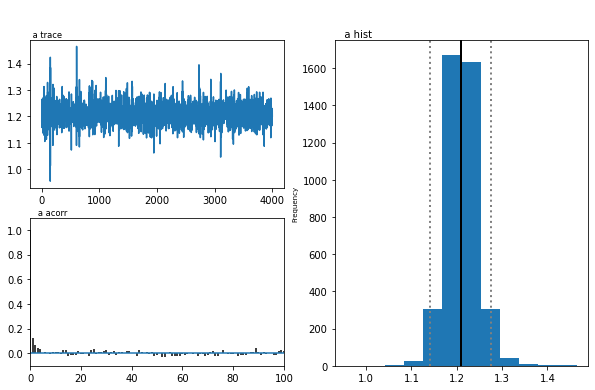

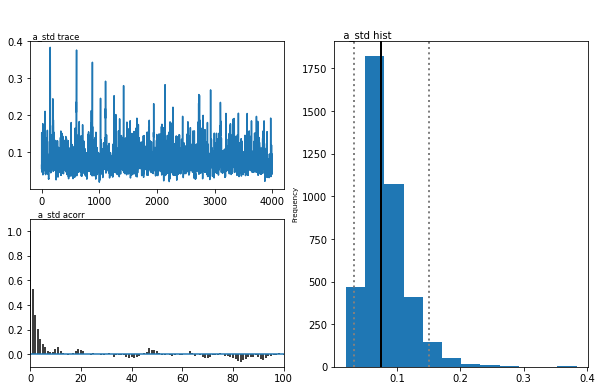

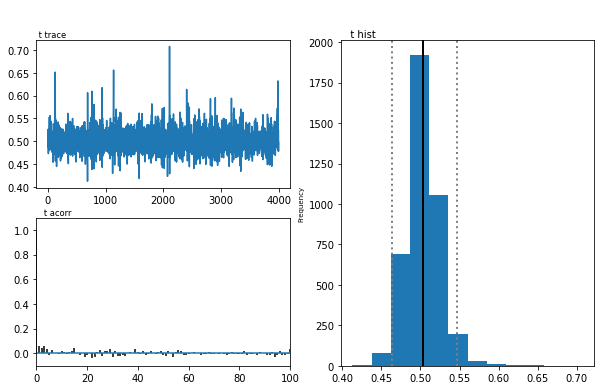

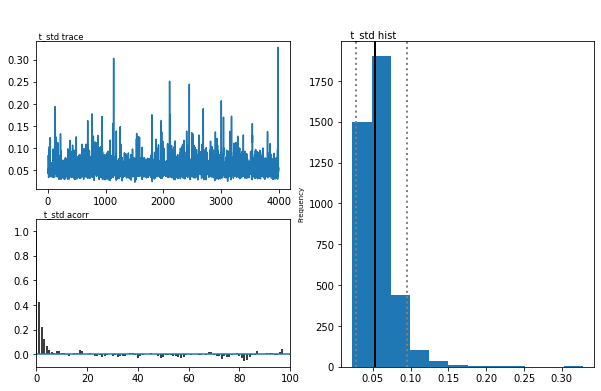

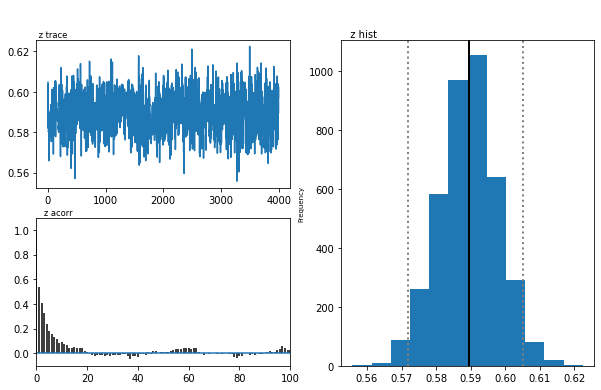

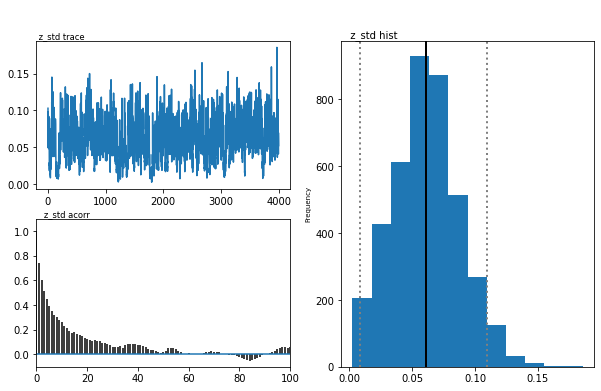

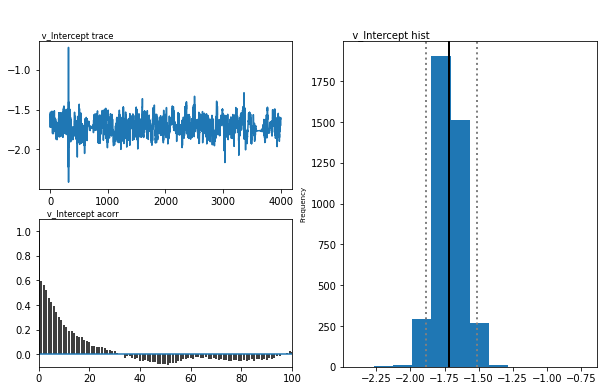

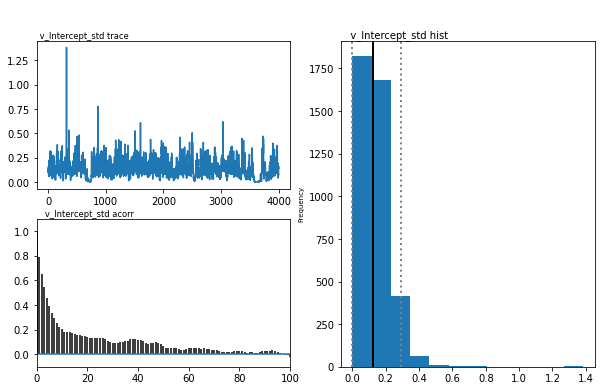

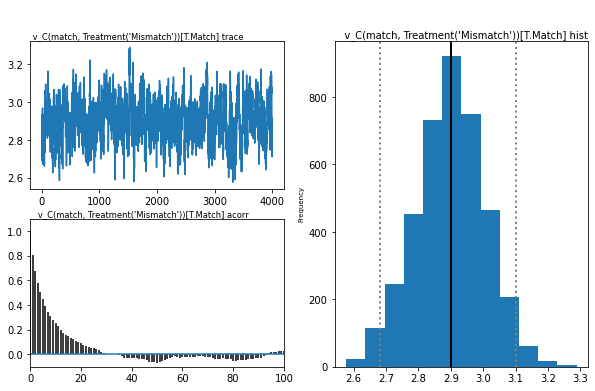

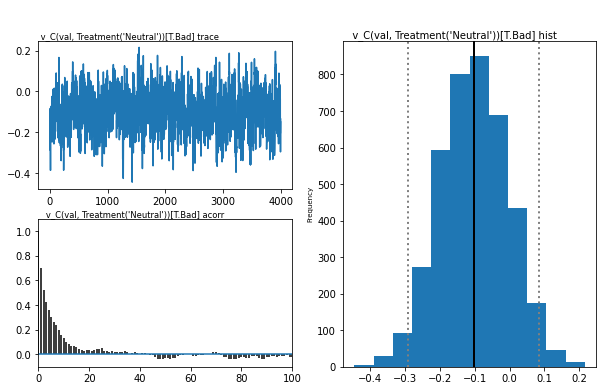

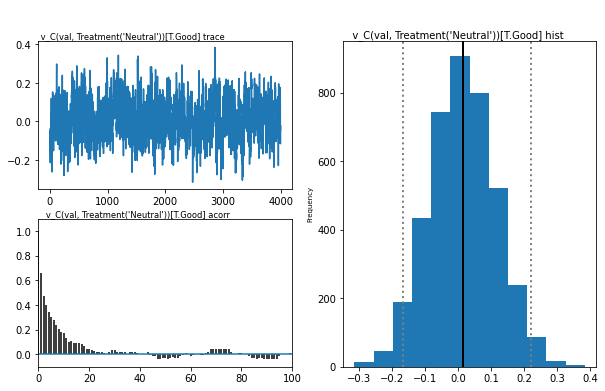

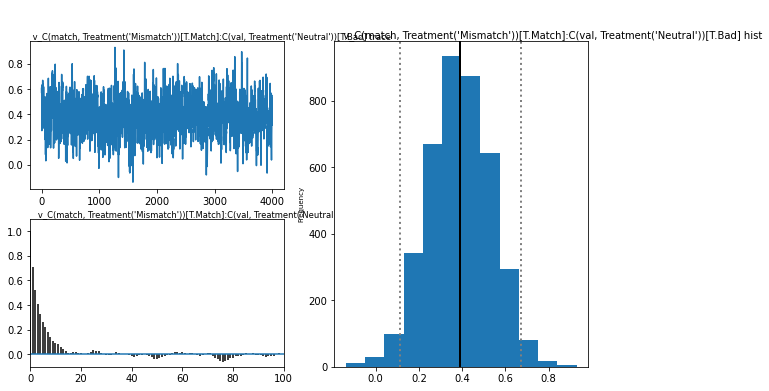

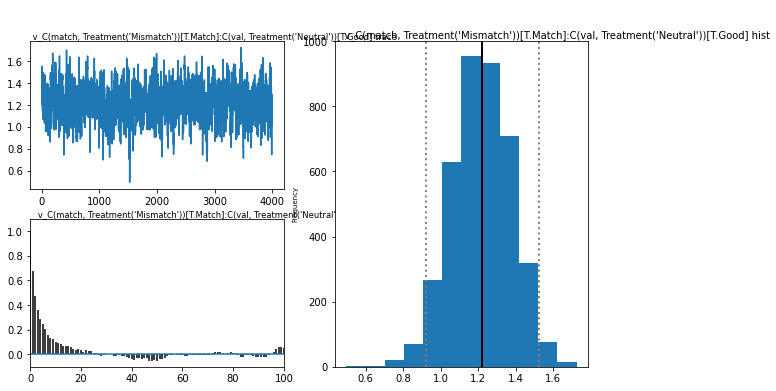

In [13]:
m_reg.plot_posteriors()

In [14]:
print("m_reg DIC: %f" % m_reg.dic) 

m_reg DIC: 186.277704


In [15]:
stats = m_reg.gen_stats()
stats

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.21058,0.0344624,1.14537,1.18987,1.21014,1.22998,1.2812,0.000726406
a_std,0.082127,0.0345906,0.0374357,0.0598194,0.0751039,0.0957048,0.166622,0.00111241
a_subj.1141,1.26006,0.0363445,1.1935,1.23564,1.25731,1.2825,1.336,0.000872852
a_subj.1143,1.19672,0.034286,1.13179,1.17297,1.19613,1.21852,1.2679,0.000827773
a_subj.1152,1.18328,0.0286692,1.12726,1.16361,1.18303,1.20265,1.23833,0.000685581
a_subj.1155,1.12656,0.0240713,1.07963,1.11097,1.12633,1.1426,1.17339,0.000604433
a_subj.1162,1.2597,0.0273431,1.20621,1.2415,1.25925,1.27842,1.31395,0.000663517
a_subj.1164,1.14374,0.0333724,1.0803,1.12131,1.14289,1.16584,1.20973,0.000850711
a_subj.1165,1.19669,0.0325301,1.12184,1.178,1.20051,1.21902,1.25239,0.00120787
a_subj.1169,1.2973,0.0307937,1.23676,1.27564,1.29753,1.31821,1.35722,0.000661859


Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

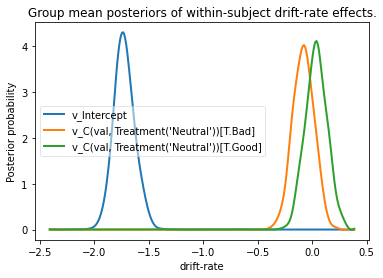

In [20]:
v_nmn, v_nmg, v_nmb = m_reg.nodes_db.loc[["v_Intercept",
                                              "v_C(val, Treatment('Neutral'))[T.Bad]",
                                              "v_C(val, Treatment('Neutral'))[T.Good]"], 'node']
#v_nmg = v_nmn + v_nmg
#v_nmb = v_nmn + v_nmb
hddm.analyze.plot_posterior_nodes([v_nmn, v_nmg, v_nmb])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

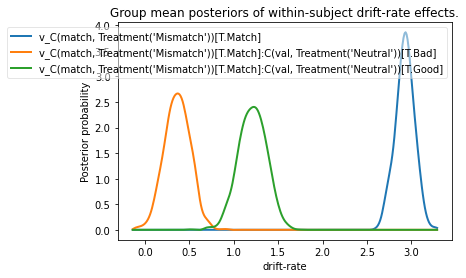

In [21]:
v_mn, v_mg, v_mb = m_reg.nodes_db.loc[["v_C(match, Treatment('Mismatch'))[T.Match]",
                                              "v_C(match, Treatment('Mismatch'))[T.Match]:C(val, Treatment('Neutral'))[T.Bad]",
                                              "v_C(match, Treatment('Mismatch'))[T.Match]:C(val, Treatment('Neutral'))[T.Good]"], 'node']
#v_nmg = v_nmn + v_nmg
#v_nmb = v_nmn + v_nmb
hddm.analyze.plot_posterior_nodes([v_mn, v_mg, v_mb])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')

In [25]:
m_reg_trace = m_reg.get_group_traces()
print(m_reg_trace.shape)

(4000, 13)


In [26]:
m_reg_trace.head(10)

,a,a_std,t,t_std,z_trans,z_std,v_Intercept,v_Intercept_std,"v_C(match, Treatment('Mismatch'))[T.Match]","v_C(val, Treatment('Neutral'))[T.Bad]","v_C(val, Treatment('Neutral'))[T.Good]","v_C(match, Treatment('Mismatch'))[T.Match]:C(val, Treatment('Neutral'))[T.Bad]","v_C(match, Treatment('Mismatch'))[T.Match]:C(val, Treatment('Neutral'))[T.Good]"
0,1.181799,0.064915,0.487365,0.053319,0.425124,0.102951,-1.560944,0.130832,2.777417,-0.285394,-0.167251,0.605089,1.475447
1,1.172202,0.054435,0.507628,0.051102,0.330952,0.089966,-1.690136,0.110332,2.787554,-0.211311,-0.113116,0.567309,1.367106
2,1.181231,0.153270,0.521213,0.042214,0.360025,0.067745,-1.677895,0.101023,2.874365,-0.206934,-0.046813,0.610358,1.323717
3,1.264720,0.090165,0.520513,0.048903,0.381599,0.097843,-1.722050,0.095500,2.932358,-0.083523,-0.093314,0.382872,1.268925
4,1.175063,0.082591,0.526556,0.045555,0.369825,0.048879,-1.661538,0.096838,2.843090,-0.093067,-0.106467,0.270480,1.359880
5,1.158298,0.132668,0.525748,0.082078,0.420738,0.072765,-1.587639,0.106699,2.775941,-0.175760,-0.213615,0.509274,1.391554
6,1.212169,0.120548,0.518354,0.083412,0.343033,0.071524,-1.531940,0.159997,2.749820,-0.241627,-0.212245,0.558964,1.311688
7,1.230006,0.113862,0.473219,0.067346,0.348719,0.084925,-1.534732,0.125737,2.689650,-0.201548,-0.090375,0.610635,1.553256
8,1.230795,0.087264,0.489461,0.068108,0.353374,0.073506,-1.593636,0.135819,2.796957,-0.331783,-0.035049,0.623583,1.198541
9,1.247197,0.072941,0.505824,0.065936,0.357290,0.066096,-1.577283,0.118182,2.773013,-0.386456,-0.089379,0.632710,1.221251


In [83]:
# rename the columns
import re

lst = ["v_", "a(", "t(", 'cha']
esc_lst = [re.escape(s) for s in lst]
pattern = '|'.join(esc_lst)

# select v, a, t, and chains
slct_columns = m_reg_trace.columns[m_reg_trace.columns.str.contains(pattern, case=False)]

slct_columns = [ x for x in slct_columns if "std" not in x ]

df_tmp = m_reg_trace[slct_columns]
df_tmp.head(10)

,v_Intercept,"v_C(match, Treatment('Mismatch'))[T.Match]","v_C(val, Treatment('Neutral'))[T.Bad]","v_C(val, Treatment('Neutral'))[T.Good]","v_C(match, Treatment('Mismatch'))[T.Match]:C(val, Treatment('Neutral'))[T.Bad]","v_C(match, Treatment('Mismatch'))[T.Match]:C(val, Treatment('Neutral'))[T.Good]"
0,-1.560944,2.777417,-0.285394,-0.167251,0.605089,1.475447
1,-1.690136,2.787554,-0.211311,-0.113116,0.567309,1.367106
2,-1.677895,2.874365,-0.206934,-0.046813,0.610358,1.323717
3,-1.722050,2.932358,-0.083523,-0.093314,0.382872,1.268925
4,-1.661538,2.843090,-0.093067,-0.106467,0.270480,1.359880
5,-1.587639,2.775941,-0.175760,-0.213615,0.509274,1.391554
6,-1.531940,2.749820,-0.241627,-0.212245,0.558964,1.311688
7,-1.534732,2.689650,-0.201548,-0.090375,0.610635,1.553256
8,-1.593636,2.796957,-0.331783,-0.035049,0.623583,1.198541
9,-1.577283,2.773013,-0.386456,-0.089379,0.632710,1.221251


In [84]:
df_tmp.columns = ['v_intercept', 'v_effect_Match', 'v_effect_NM_Bad', 'v_effect_NM_Good', 'v_Match:Bad', 'v_Match:Good'] 
df_tmp.head(10)

,v_intercept,v_effect_Match,v_effect_NM_Bad,v_effect_NM_Good,v_Match:Bad,v_Match:Good
0,-1.560944,2.777417,-0.285394,-0.167251,0.605089,1.475447
1,-1.690136,2.787554,-0.211311,-0.113116,0.567309,1.367106
2,-1.677895,2.874365,-0.206934,-0.046813,0.610358,1.323717
3,-1.722050,2.932358,-0.083523,-0.093314,0.382872,1.268925
4,-1.661538,2.843090,-0.093067,-0.106467,0.270480,1.359880
5,-1.587639,2.775941,-0.175760,-0.213615,0.509274,1.391554
6,-1.531940,2.749820,-0.241627,-0.212245,0.558964,1.311688
7,-1.534732,2.689650,-0.201548,-0.090375,0.610635,1.553256
8,-1.593636,2.796957,-0.331783,-0.035049,0.623583,1.198541
9,-1.577283,2.773013,-0.386456,-0.089379,0.632710,1.221251


In [90]:
df_tmp.loc[:,'NM_Neut'] = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_NM_Bad'].copy()

In [91]:
df_tmp.loc[:,'NM_Neut'] = df_tmp.loc[:,'v_intercept'].copy()
df_tmp.loc[:,'NM_Bad']  = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_NM_Bad'].copy()
df_tmp.loc[:,'NM_Good'] = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_NM_Good'].copy()
df_tmp.loc[:,'M_Neut']  = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_Match'].copy()
df_tmp.loc[:,'M_Bad']   = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_Match'].copy() + df_tmp.loc[:, 'v_Match:Bad'].copy()
df_tmp.loc[:,'M_Good']  = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_Match'].copy() + df_tmp.loc[:, 'v_Match:Good'].copy()


In [92]:
df_tmp = df_tmp.loc[:, ['NM_Neut', 'NM_Bad', 'NM_Good', 'M_Neut', 'M_Bad', 'M_Good']]
df_tmp.head(10)

,NM_Neut,NM_Bad,NM_Good,M_Neut,M_Bad,M_Good
0,-1.560944,-1.846338,-1.728195,1.216473,1.821562,2.691920
1,-1.690136,-1.901447,-1.803252,1.097418,1.664728,2.464525
2,-1.677895,-1.884829,-1.724708,1.196470,1.806828,2.520187
3,-1.722050,-1.805573,-1.815364,1.210308,1.593180,2.479233
4,-1.661538,-1.754605,-1.768005,1.181552,1.452032,2.541432
5,-1.587639,-1.763399,-1.801253,1.188302,1.697576,2.579856
6,-1.531940,-1.773567,-1.744185,1.217880,1.776844,2.529568
7,-1.534732,-1.736280,-1.625107,1.154917,1.765552,2.708173
8,-1.593636,-1.925419,-1.628685,1.203320,1.826903,2.401862
9,-1.577283,-1.963739,-1.666662,1.195730,1.828440,2.416981


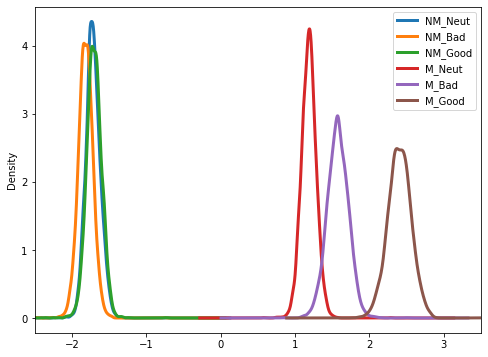

In [93]:
df_tmp.plot.density(figsize=(8,6),xlim=(-2.5, 3.5),linewidth=3)

In [47]:


df_tmp["id"] = df_tmp.index
# df_tmp.head()
print('Shape of the wide format', df_tmp.shape)

df_melt = pd.melt(df_tmp,
                  id_vars=['id'],
                  value_vars=['NM_Neut', 'NM_Bad', 'NM_Good', 'M_Neut', 'M_Bad', 'M_Good'],
                  var_name='cond',
                  value_name='value')

#type(df_melt)
print('Shape of the long format', df_melt.shape)
df_melt.head()

Shape of the wide format (4000, 7)
Shape of the long format (24000, 3)


,id,cond,value
0,0,NM_Neut,-1.560944
1,1,NM_Neut,-1.690136
2,2,NM_Neut,-1.677895
3,3,NM_Neut,-1.722050
4,4,NM_Neut,-1.661538


In [48]:
# split the cond column into three columns
df_melt[['Matchness','Valence']] = pd.DataFrame(df_melt['cond'].apply(lambda x: [i for i in re.split(r'[\_\.]', x) if len(i)>0]).to_list())
df_melt.head()

,id,cond,value,Matchness,Valence
0,0,NM_Neut,-1.560944,NM,Neut
1,1,NM_Neut,-1.690136,NM,Neut
2,2,NM_Neut,-1.677895,NM,Neut
3,3,NM_Neut,-1.722050,NM,Neut
4,4,NM_Neut,-1.661538,NM,Neut


ValueError: could not convert string to float: 'NM_Neut'

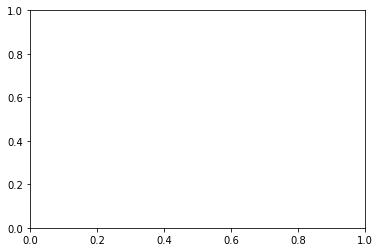

In [51]:
df_melt['cond_c'] = pd.Categorical(df_melt['cond'], categories=['NM_Bad', 'NM_Neut', 'NM_Good', 'M_Bad', 'M_Neut',  'M_Good'])

import seaborn as sns
sns.kdeplot(data=df_melt, x="value", hue="cond_c")